### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

import time
from sklearn import metrics

### Getting Data
##### Getting Data From Csv's

In [2]:
cards_data = pd.read_csv('datasets/cards_data.csv')
users_data = pd.read_csv('datasets/users_data.csv')
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


##### Getting Data From Json's

In [3]:
with open('datasets/mcc_codes.json','r') as mcc_codes:
    data = json.load(mcc_codes)
with open('datasets/train_fraud_labels.json','r') as fraud_label:
    target = json.load(fraud_label)

In [4]:
mcc_codes = pd.DataFrame(list(data.items()), columns=['mcc', 'Description'])
fraud_label_target = pd.DataFrame(list(target.get('target').items()), columns=['transaction_id', 'fraud'])

##### Getting Data from Database

In [5]:
from db_connection import connect_to_db
connection = connect_to_db()
query = "SELECT * FROM transaction"
transaction_data = pd.read_sql(query, connection)

In [6]:
fraud_label_target.transaction_id  = fraud_label_target.transaction_id.astype(int)
transaction_data.date = pd.to_datetime(transaction_data.date)

### Merging and preprocessing the required DataFrames

In [7]:
transaction_data.head()

,id,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None


In [8]:
online_mask = transaction_data['merchant_city'] == 'ONLINE'
transaction_data.loc[online_mask, 'merchant_state'] = 'ONLINE'
transaction_data.loc[online_mask, 'zip'] = 'ONLINE'
transaction_data['zip'] = transaction_data['zip'].fillna('FOREIGN') 

In [9]:
import pgeocode

nomi = pgeocode.Nominatim('us')

valid_zip_mask = ~transaction_data['zip'].isin(['ONLINE', 'FOREIGN'])
numeric_zip_mask = transaction_data['zip'].apply(lambda x: str(x).isdigit() if pd.notna(x) else False)
valid_zips = transaction_data.loc[valid_zip_mask & numeric_zip_mask, 'zip'].astype(str)

unique_zips = valid_zips.unique()

lat_lon_lookup = pd.DataFrame(unique_zips, columns=['zip'])
lat_lon_lookup[['t_latitude', 't_longitude']] = lat_lon_lookup['zip'].apply(
    lambda z: pd.Series(nomi.query_postal_code(z)[['latitude', 'longitude']])
)

transaction_data = transaction_data.merge(lat_lon_lookup, on='zip', how='left')

In [10]:
transaction_data['transaction_type'] = transaction_data.apply(
    lambda row: 'ONLINE' if row['zip'] == 'ONLINE' 
    else ('FOREIGN' if row['zip'] == 'FOREIGN' else 'OFFLINE'),
    axis=1
)

In [11]:
transaction_data['repeat_transaction'] = transaction_data.duplicated(
    subset=['client_id', 'merchant_id','transaction_type'], keep='first'
)
transaction_data['repeat_transaction'] = transaction_data['repeat_transaction'].astype(int)

In [12]:
transaction_fraud = transaction_data.merge(fraud_label_target,how='left',left_on='id', right_on='transaction_id')
transaction_fraud.drop(['id','transaction_id'],inplace=True,axis =1)

In [13]:
main_df = transaction_fraud.merge(users_data[['id','latitude', 'longitude']],how='left',left_on='client_id', right_on='id')
main_df.drop('id',inplace=True,axis =1)

In [14]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,t_latitude,t_longitude,transaction_type,repeat_transaction,fraud,latitude,longitude
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,47.2707,-101.8075,OFFLINE,0,No,46.80,-100.76
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,41.5509,-90.4942,OFFLINE,0,No,40.80,-91.12
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,33.2131,-117.2243,OFFLINE,0,No,33.18,-117.29
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,41.4236,-87.3556,OFFLINE,0,NaN,41.42,-87.35
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,38.8582,-76.6145,OFFLINE,0,No,38.86,-76.60


In [15]:
mask = (
    (main_df['transaction_type'] == 'OFFLINE') &
    main_df[['latitude','longitude','t_latitude','t_longitude']].notna().all(axis=1)
)

# Vectorized haversine
lat1 = np.radians(main_df.loc[mask, 'latitude'])
lon1 = np.radians(main_df.loc[mask, 'longitude'])
lat2 = np.radians(main_df.loc[mask, 't_latitude'])
lon2 = np.radians(main_df.loc[mask, 't_longitude'])

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

main_df.loc[mask, 'distance_km'] = 6371.0 * c  # Earth radius in km

# Optional: distance in miles
main_df['distance_miles'] = main_df['distance_km'] * 0.621371

In [16]:
del lat_lon_lookup
del valid_zips
del unique_zips
del users_data
del cards_data
del mcc_codes
del transaction_data
del transaction_fraud
del mask


import gc
gc.collect()

0

In [17]:
main_df['updated_amt'] = np.where(main_df.amount<0,main_df.amount*-1,main_df.amount)
main_df['fraud'] = main_df['fraud'].map({'Yes': 1, 'No': 0})
main_df.fraud.isna().sum()


np.int64(4390952)

In [18]:
main_df = main_df.drop((['merchant_city','merchant_state','zip','mcc','error','t_latitude','t_longitude','latitude','longitude']),axis=1)

In [19]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,transaction_type,repeat_transaction,fraud,distance_km,distance_miles,updated_amt
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,OFFLINE,0,0.0,95.084379,59.082675,77.00
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,OFFLINE,0,0.0,98.563877,61.244735,14.57
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,OFFLINE,0,0.0,7.135686,4.433909,80.00
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,OFFLINE,0,NaN,0.615033,0.382164,200.00
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,OFFLINE,0,0.0,1.271358,0.789985,46.41


In [20]:
final_test_df = main_df[main_df.fraud.isna()].drop('fraud',axis =1)
main_df = main_df[~main_df.fraud.isna()]

In [21]:
final_test_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,transaction_type,repeat_transaction,distance_km,distance_miles,updated_amt
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,OFFLINE,0,0.615033,0.382164,200.00
6,2010-01-01 00:09:00,1556,2972,77.00,Swipe Transaction,59935,OFFLINE,1,95.084379,59.082675,77.00
8,2010-01-01 00:21:00,335,5131,261.58,Online Transaction,50292,ONLINE,0,NaN,NaN,261.58
9,2010-01-01 00:21:00,351,1112,10.74,Swipe Transaction,3864,OFFLINE,0,2.339468,1.453677,10.74
15,2010-01-01 00:31:00,1634,2464,1.09,Swipe Transaction,20519,OFFLINE,0,46.724910,29.033504,1.09


In [22]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,transaction_type,repeat_transaction,fraud,distance_km,distance_miles,updated_amt
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,OFFLINE,0,0.0,95.084379,59.082675,77.00
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,OFFLINE,0,0.0,98.563877,61.244735,14.57
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,OFFLINE,0,0.0,7.135686,4.433909,80.00
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,OFFLINE,0,0.0,1.271358,0.789985,46.41
5,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,OFFLINE,0,0.0,6.990452,4.343664,4.81


In [ ]:
def create_comprehensive_features(df, train_end_date='2017-12-31', lookback_days=180,verbose=True):  
    df = df.sort_values(['client_id', 'card_id', 'date']).reset_index(drop=True)
    
    if isinstance(train_end_date, str):
        train_end_date = pd.to_datetime(train_end_date)
    
    train_mask = df['date'] <= train_end_date
    train_df = df[train_mask]
    
    if verbose:
        print("=" * 60)
        print("Creating Comprehensive Features (No Leakage)")
        print("=" * 60)
        print(f"Training: {train_mask.sum():,} transactions")
        print(f"Test/Future: {(~train_mask).sum():,} transactions")
    

    if verbose:
        print("\n1. Computing merchant-level features from training data...")
    
    merchant_stats = train_df.groupby('merchant_id').agg(
        merchant_fraud_rate=('fraud', 'mean'),
        merchant_total_txns=('fraud', 'count'),
        merchant_avg_amount=('updated_amt', 'mean')
    ).reset_index()
    
    # Merge to all data
    df = df.merge(merchant_stats, on='merchant_id', how='left')
    df['merchant_fraud_rate'] = df['merchant_fraud_rate'].fillna(0)
    df['merchant_total_txns'] = df['merchant_total_txns'].fillna(0)
    df['merchant_avg_amount'] = df['merchant_avg_amount'].fillna(df['updated_amt'].median())
    
    if verbose:
        print(f"   Merchant fraud rate - Mean: {df['merchant_fraud_rate'].mean():.4f}")
        print(f"   Unique merchants: {df['merchant_id'].nunique():,}")
    
    del merchant_stats
    gc.collect()
    
    if verbose:
        print("\n2. Computing user-level features with temporal constraints...")
    
    df['user_avg_amount_180d'] = 0.0
    df['user_std_amount_180d'] = 0.0
    df['user_fraud_count_180d'] = 0
    df['user_txn_count_180d'] = 0
    df['amount_deviation'] = 0.0
    
    lookback_td = pd.Timedelta(days=lookback_days)
    
    processed = 0
    total_groups = df.groupby(['client_id', 'card_id']).ngroups
    
    for (cid, card), g in df.groupby(['client_id', 'card_id'], sort=False):
        processed += 1
        if verbose and processed % 10000 == 0:
            print(f"   Progress: {processed:,}/{total_groups:,} groups")
        
        idx = g.index.values
        dates = g['date'].values
        amounts = g['updated_amt'].values
        frauds = g['fraud'].values
        n = len(idx)
        
        user_avg = np.zeros(n, dtype=np.float32)
        user_std = np.zeros(n, dtype=np.float32)
        user_fraud_cnt = np.zeros(n, dtype=np.int32)
        user_txn_cnt = np.zeros(n, dtype=np.int32)
        amt_dev = np.zeros(n, dtype=np.float32)
        
        left = 0
        
        for right in range(n):
            current_date = dates[right]
            cutoff_date = current_date - lookback_td
            
            # For test/future data, only use training history
            if current_date > train_end_date:
                # Cap the lookback window at train_end_date
                effective_cutoff = cutoff_date
                
                # Find all historical transactions in [cutoff_date, train_end_date]
                hist_mask = (dates < current_date) & \
                            (dates >= effective_cutoff) & \
                            (dates <= train_end_date)
                
                hist_amounts = amounts[hist_mask]
                hist_frauds = frauds[hist_mask]
            else:
                # normal rolling window
                while left < right and dates[left] < cutoff_date:
                    left += 1
                
                hist_amounts = amounts[left:right]
                hist_frauds = frauds[left:right]
            
            # Compute statistics
            if len(hist_amounts) > 0:
                user_avg[right] = hist_amounts.mean()
                user_std[right] = hist_amounts.std() if len(hist_amounts) > 1 else 0
                user_fraud_cnt[right] = hist_frauds.sum()
                user_txn_cnt[right] = len(hist_amounts)
                
                # Amount deviation
                if user_std[right] > 0:
                    amt_dev[right] = (amounts[right] - user_avg[right]) / user_std[right]
        
        df.loc[idx, 'user_avg_amount_180d'] = user_avg
        df.loc[idx, 'user_std_amount_180d'] = user_std
        df.loc[idx, 'user_fraud_count_180d'] = user_fraud_cnt
        df.loc[idx, 'user_txn_count_180d'] = user_txn_cnt
        df.loc[idx, 'amount_deviation'] = amt_dev
    
    if verbose:
        print(f"   Progress: {processed:,}/{total_groups:,} groups - Complete!")
    
  
    df['user_fraud_rate_180d'] = np.where(
        df['user_txn_count_180d'] > 0,
        df['user_fraud_count_180d'] / df['user_txn_count_180d'],
        0
    )
    
    df['amount_vs_merchant_avg'] = df['updated_amt'] / df['merchant_avg_amount']
    df['amount_vs_user_avg'] = np.where(
        df['user_avg_amount_180d'] > 0,
        df['updated_amt'] / df['user_avg_amount_180d'],
        1
    )
    

    if verbose:
        print("\n" + "=" * 60)
        print("Feature Summary (All Data)")
        print("=" * 60)
        print(f"Merchant fraud rate    - Mean: {df['merchant_fraud_rate'].mean():.4f}")
        print(f"User fraud rate (180d) - Mean: {df['user_fraud_rate_180d'].mean():.4f}")
        print(f"Amount deviation       - Mean: {df['amount_deviation'].mean():.2f}, Std: {df['amount_deviation'].std():.2f}")
        
        print("\n" + "=" * 60)
        print("Feature Summary (Test/Future Only)")
        print("=" * 60)
        test_data = df[~train_mask]
        if len(test_data) > 0:
            print(f"User fraud rate (180d) - Mean: {test_data['user_fraud_rate_180d'].mean():.4f}")
            print(f"Amount deviation       - Mean: {test_data['amount_deviation'].mean():.2f}")
            print(f"Transactions with history: {(test_data['user_txn_count_180d'] > 0).sum():,}/{len(test_data):,}")
        print("=" * 60)
    
    return df

In [24]:
main_df = create_comprehensive_features(main_df, pd.to_datetime('2017-12-31') ,lookback_days=180)

Creating Comprehensive Features (No Leakage)
Training: 7,200,656 transactions
Test/Future: 1,714,307 transactions

1. Computing merchant-level features from training data...
   Merchant fraud rate - Mean: 0.0014
   Unique merchants: 66,537

2. Computing user-level features with temporal constraints...
   Progress: 4,070/4,070 groups - Complete!

Feature Summary (All Data)
Merchant fraud rate    - Mean: 0.0014
User fraud rate (180d) - Mean: 0.0012
Amount deviation       - Mean: 0.05, Std: 9.07

Feature Summary (Test/Future Only)
User fraud rate (180d) - Mean: 0.0002
Amount deviation       - Mean: 0.07
Transactions with history: 454,225/1,714,307


In [25]:
main_df['distance_km'] = main_df['distance_km'].fillna(0)

main_df['amount_deviation_capped'] = main_df['amount_deviation'].clip(-10, 10)

main_df['user_has_fraud_history'] = (main_df['user_fraud_rate_180d'] > 0).astype(int)

main_df['is_refund'] = (main_df['amount']<0).astype(int)

main_df['amount_log'] = np.log1p(main_df['updated_amt'])

main_df['no_distance'] = (main_df['distance_km'] ==0).astype(int)
main_df['distance_very_close'] = ((main_df['distance_km'] < 1) & (main_df['distance_km']>0)).astype(int)
main_df['distance_very_far'] = (main_df['distance_km'] > 500).astype(int)
main_df['distance_log'] = np.log1p(main_df['distance_km'])

main_df['amount_x_merchant_risk'] = main_df['amount'] * main_df['merchant_fraud_rate']

main_df['amount_vs_user_avg_capped'] = main_df['amount_vs_user_avg'].clip(0, 10)

cap_99 = main_df['amount_x_merchant_risk'].quantile(0.95)
main_df['amount_x_merchant_risk_capped'] = main_df['amount_x_merchant_risk'].clip(0, cap_99)
    

In [26]:
core_features = ['date','updated_amt','merchant_fraud_rate','user_has_fraud_history','amount_x_merchant_risk_capped','user_fraud_count_180d','amount_vs_user_avg_capped','transaction_type','transaction_mode','fraud']
main_df = main_df[core_features]
main_df.head()

,date,updated_amt,merchant_fraud_rate,user_has_fraud_history,amount_x_merchant_risk_capped,user_fraud_count_180d,amount_vs_user_avg_capped,transaction_type,transaction_mode,fraud
0,2011-02-01 07:12:00,81.10,0.000012,0,0.001005,0,1.000000,OFFLINE,Swipe Transaction,0.0
1,2011-02-01 12:53:00,55.00,0.000025,0,0.000000,0,0.678175,OFFLINE,Swipe Transaction,0.0
2,2011-02-01 13:46:00,3.20,0.000000,0,0.000000,0,0.047024,OFFLINE,Swipe Transaction,0.0
3,2011-02-01 19:48:00,5.28,0.000000,0,0.000000,0,0.113711,OFFLINE,Swipe Transaction,0.0
4,2011-02-03 06:23:00,11.16,0.000012,0,0.000138,0,0.308756,OFFLINE,Swipe Transaction,0.0


##### Code for detailed Analysis and EDA - https://github.com/yashjadwani/Financial-Fraud-Analysis/blob/main/fraud_detection.ipynb

In [27]:
round(main_df.describe(),4)

,date,updated_amt,merchant_fraud_rate,user_has_fraud_history,amount_x_merchant_risk_capped,user_fraud_count_180d,amount_vs_user_avg_capped,fraud
count,8914963,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06
mean,2015-01-06 10:38:50.359854848,5.311870e+01,1.400000e-03,3.870000e-02,4.300000e-02,1.709000e-01,1.005300e+00,1.500000e-03
min,2010-01-01 00:01:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2012-08-09 10:34:00,1.175000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.262000e-01,0.000000e+00
50%,2015-01-22 14:06:00,3.481000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.889000e-01,0.000000e+00
75%,2017-06-13 19:22:30,7.097000e+01,8.000000e-04,0.000000e+00,1.200000e-02,0.000000e+00,1.190500e+00,0.000000e+00
max,2019-10-31 23:57:00,6.613440e+03,1.000000e+00,1.000000e+00,3.618000e-01,2.300000e+01,1.000000e+01,1.000000e+00
std,NaN,7.529690e+01,1.260000e-02,1.930000e-01,9.830000e-02,1.066400e+00,1.096100e+00,3.860000e-02


## Model Building

In [28]:
mask = main_df['date'] <= '2017-12-31'

train_df = main_df[mask].drop(columns=['date'])
test_df  = main_df[~mask].drop(columns=['date'])

X_train_full = train_df.drop(columns=['fraud'])
y_train_full = train_df['fraud']

X_test_full = test_df.drop(columns=['fraud'])
y_test_full = test_df['fraud']

X_train_genuine = X_train_full[y_train_full == 0]

In [29]:
X_train_full.head()

,updated_amt,merchant_fraud_rate,user_has_fraud_history,amount_x_merchant_risk_capped,user_fraud_count_180d,amount_vs_user_avg_capped,transaction_type,transaction_mode
0,81.10,0.000012,0,0.001005,0,1.000000,OFFLINE,Swipe Transaction
1,55.00,0.000025,0,0.000000,0,0.678175,OFFLINE,Swipe Transaction
2,3.20,0.000000,0,0.000000,0,0.047024,OFFLINE,Swipe Transaction
3,5.28,0.000000,0,0.000000,0,0.113711,OFFLINE,Swipe Transaction
4,11.16,0.000012,0,0.000138,0,0.308756,OFFLINE,Swipe Transaction


##### Anamoly Detection AutoEncoder

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class AutoencoderGMMDetector(BaseEstimator, TransformerMixin):
    def __init__(self, code_dim=2, epochs=25, batch_size=256, n_components=2,
                 learning_rate=0.001, anomaly_percentile=5,dropout_rate=0.3,
                 l2_reg=0.001):
        self.code_dim = code_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.anomaly_percentile = anomaly_percentile
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        
        self.autoencoder = None
        self.gmm = None
        self.threshold = None
        self._history = None  
    
    def build_model(self, input_shape):
        reg = l2(self.l2_reg)
        inp = Input(shape=(input_shape,))
        x = Dense(64, activation='relu',kernel_regularizer=reg)(inp) 
        x = Dropout(self.dropout_rate)(x)
        x = Dense(32, activation='relu',kernel_regularizer=reg)(x)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(16, activation='relu',kernel_regularizer=reg)(x)
        code = Dense(self.code_dim, activation='relu')(x)
        x = Dense(16, activation='relu',kernel_regularizer=reg)(code)
        x = Dense(32, activation='relu',kernel_regularizer=reg)(x)
        x = Dense(64, activation='relu',kernel_regularizer=reg)(x)
        out = Dense(input_shape, activation='linear')(x)
        return Model(inp, out)
    
    def fit(self, X, y=None):
        input_shape = X.shape[1]
        self.autoencoder = self.build_model(input_shape)
        self.autoencoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')

        earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-5, restore_best_weights=True, verbose=1)

        self._history = self.autoencoder.fit(
            X, X,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=0.30,
            callbacks=[earlystop],
            shuffle=True,
            verbose=1
        )

        # Compute reconstruction errors
        recon = self.autoencoder.predict(X, batch_size=self.batch_size, verbose=0)
        errors = np.mean(np.abs(recon - X), axis=1).reshape(-1,1)

        # Fit GMM
        self.gmm = GaussianMixture(n_components=self.n_components, covariance_type='full', random_state=42)
        self.gmm.fit(errors)

        # Threshold = bottom percentile of log-likelihood
        log_likelihood = self.gmm.score_samples(errors)
        self.threshold = np.percentile(log_likelihood, self.anomaly_percentile)
        print(f"Anomaly log-likelihood threshold set at {self.threshold:.6f} "
              f"(bottom {self.anomaly_percentile} percentile)")

        return self

    @property
    def history(self):
        return self._history

    def score_samples(self, X):
        recon = self.autoencoder.predict(X, batch_size=self.batch_size, verbose=0)
        errors = np.mean(np.abs(recon - X), axis=1).reshape(-1,1)
        return self.gmm.score_samples(errors)

    def predict(self, X):
        scores = self.score_samples(X)
        return (scores < self.threshold).astype(int)  # 1 = anomaly/fraud

    def plot_training_loss(self):
        plt.figure(figsize=(10,6))
        plt.plot(self._history.history['loss'], label='Training Loss')
        plt.plot(self._history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Autoencoder Training Curve(Loss Function)')
        plt.legend()
        plt.grid(True)
        plt.show()

* The purpose of this fully-connected feedforward autoencoder is to identify anomalies in transaction data. An encoder (64 → 32 → 16 → code) compresses the input features into a low-dimensional latent space (code_dim), which is then reconstructed using a symmetric decoder (16 → 32 → 64 → output). Anomaly likelihoods are calculated by modelling the reconstruction error using a Gaussian Mixture Model (GMM). Anomalies (possible fraud) are transactions whose log-likelihood is less than the designated percentile (anomaly_percentile). Early halting avoids overfitting, and the network is trained using Mean Squared Error (MSE) loss with Adam optimiser.

* For a more detailed explanation of this autoencoder, please see [Anomaly Detection Autoencoders](https://github.com/yashjadwani/Autoencoder)

In [64]:
### Evaluation Metrics
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve

def eval_autoencoder(y_test,y_preds):
    print(f"Accuracy: {accuracy_score(y_test, y_preds):.4f}")
    print(f"Precision: {precision_score(y_test, y_preds, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_preds, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_preds, zero_division=0):.4f}")
    print(f"Matthews Corrcoef: {matthews_corrcoef(y_test, y_preds):.4f}")
    print(f"Correctly Predicted Samples: {(y_preds == y_test).sum()} / {len(y_test)}")
    print('=================================================')
    confusion_matrix = metrics.confusion_matrix(y_test, y_preds)
    print(confusion_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=['Non-Fraud', 'Fraud']
    )
    cm_display.plot(cmap='Blues')
    plt.show()

In [63]:
#### Evaluation Metrics for XGB 

def eval_classification(pipeline,x_test, y_test):
    y_probs = pipeline.predict_proba(x_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]
    print("Best threshold:", best_threshold)

    y_pred = (y_probs >= best_threshold).astype(int)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Matthews Corrcoef: {matthews_corrcoef(y_test, y_pred):.4f}")
    print(f"Correctly Predicted Samples: {(y_pred == y_test).sum()} / {len(y_test)}")
    print('=================================================')
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    print(confusion_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=['Non-Fraud', 'Fraud']
    )
    cm_display.plot(cmap='Blues')
    plt.show()


#### Classifiers

In [ ]:
from xgboost import XGBClassifier

scale_pos_weight = (y_train_full == 0).sum() / (y_train_full == 1).sum()

XGB_Classifier = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='aucpr',
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    use_label_encoder=False
)


#### Preprocess

In [72]:
from sklearn.preprocessing import StandardScaler


cat_cols = ['transaction_type', 'transaction_mode']
continuous_features = ['amount_x_merchant_risk_capped','amount_vs_user_avg_capped']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), continuous_features)
    ]
)

In [36]:
del mask
del train_df
del test_df

gc.collect()

0

##### Auto Encoder training

In [73]:
autoencoder_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('autoencoder', AutoencoderGMMDetector(code_dim=2, epochs=50, batch_size=256, n_components=2,learning_rate=0.001,anomaly_percentile=3))
])

autoencoder_pipeline.fit(X_train_genuine)

Epoch 1/50
19662/19662 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - loss: 0.0505 - val_loss: 0.0356
Epoch 2/50
19662/19662 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - loss: 0.0350 - val_loss: 0.0309
Epoch 3/50
19662/19662 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - loss: 0.0321 - val_loss: 0.0295
Epoch 4/50
19662/19662 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 0.0303 - val_loss: 0.0258
Epoch 5/50
19662/19662 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - loss: 0.0293 - val_loss: 0.0292
Epoch 6/50
19662/19662 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - loss: 0.0287 - val_loss: 0.0267
Epoch 7/50
19662/19662 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - loss: 0.0280 - val_loss: 0.0273
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.
Anomaly log-likelihood threshold set at -0.506173 (bottom 3 percentile)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['transaction_type',
                                                   'transaction_mode']),
                                                 ('num', StandardScaler(),
                                                  ['amount_x_merchant_risk_capped',
                                                   'amount_vs_user_avg_capped'])])),
                ('autoencoder',
                 AutoencoderGMMDetector(anomaly_percentile=3, epochs=50))])

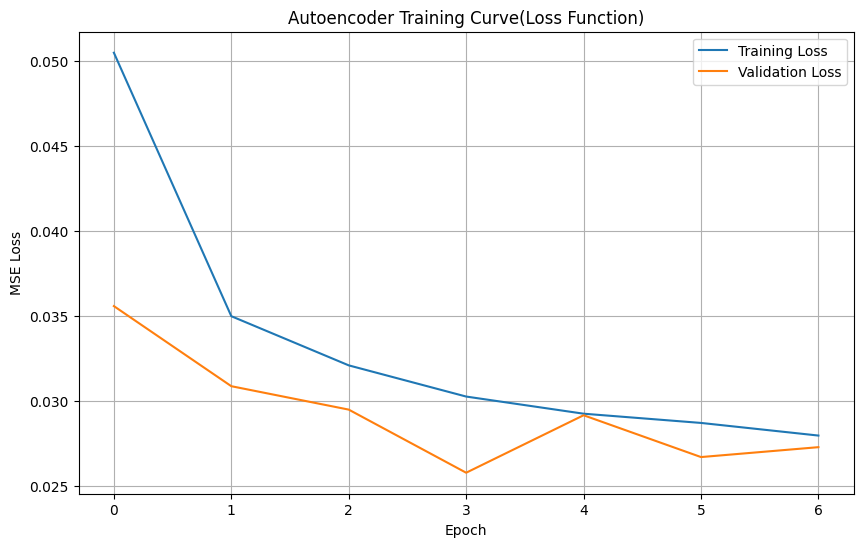

c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Accuracy: 0.9860
Precision: 0.0911
Recall: 0.7777
F1 Score: 0.1632
Matthews Corrcoef: 0.2633
Correctly Predicted Samples: 1690376 / 1714307
[[1688043   23264]
 [    667    2333]]


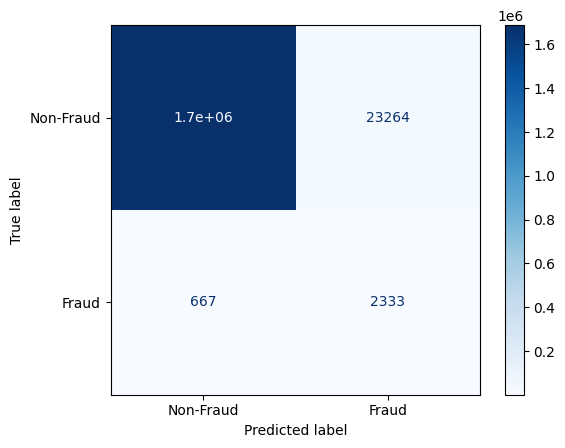

In [74]:
autoencoder_pipeline.named_steps['autoencoder'].plot_training_loss()

X_test_full['anomaly_flag'] = autoencoder_pipeline.predict(X_test_full)
X_test_full['anomaly_score'] = autoencoder_pipeline.score_samples(X_test_full)

eval_autoencoder(y_test_full,X_test_full['anomaly_flag'])

##### Classification training

In [55]:

cat_cols = ['transaction_type', 'transaction_mode']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ]
)

In [75]:
xgb_pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', XGB_Classifier)
])

xgb_pipeline.fit(X_train_full,y_train_full)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['transaction_type',
                                                   'transaction_mode']),
                                                 ('num', StandardScaler(),
                                                  ['amount_x_merchant_risk_capped',
                                                   'amount_vs_user_avg_capped'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsampl...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, ...))])

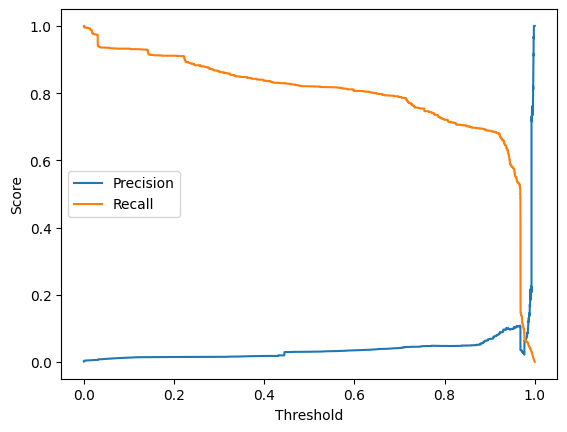

Best threshold: 0.96719253
Accuracy: 0.9916
Precision: 0.1082
Recall: 0.5210
F1 Score: 0.1792
Matthews Corrcoef: 0.2348
Correctly Predicted Samples: 1699989 / 1714307
[[1698426   12881]
 [   1437    1563]]


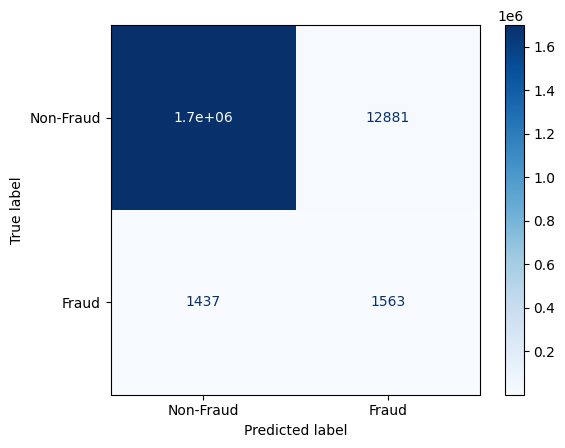

In [76]:
eval_classification(xgb_pipeline,X_test_full,y_test_full)

In [ ]:
import joblib
import json
import os
save_dir = "Models/AutoEncoders"


joblib.dump(preprocess, os.path.join(save_dir, "autoencoder_preprocess.pkl"))

detector = autoencoder_pipeline.named_steps["autoencoder"]
detector.autoencoder.save(os.path.join(save_dir, "autoencoder_autoencoder.keras"))

joblib.dump(detector.gmm,  os.path.join(save_dir, "autoencoder_gmm.pkl"))

with open(os.path.join(save_dir, "autoencoder_threshold.json"), "w") as f:
        json.dump({"threshold": float(detector.threshold)}, f)

save_dir = "Models/Classifier"
joblib.dump(XGB_Classifier, os.path.join(save_dir, "xgb_classifier.pkl"))